In [15]:
# !pip install retina-face

In [16]:
# !pip install git+https://github.com/tensorflow/docs

In [10]:
import cv2
from retinaface import RetinaFace
from tensorflow.keras.models import load_model
import numpy as np
from keras.models import load_model
import time


In [11]:
def extract_region(image, box):
    if box is None or len(box) != 4:
        return None
    x, y, w, h = box
    return image[y:y+h, x:x+w]

def preprocess_input(face_region):
    if face_region is None or face_region.size == 0:
        print("Error: face_region is empty or None.")
        return None
    face_region = cv2.resize(face_region, (224, 224))
    face_region = face_region.astype('float32')
    face_region /= 255  
    face_region = np.expand_dims(face_region, axis=0)  
    return face_region

def get_feature_region(face, feature):
    image_shape = face['image_shape']
    
    if feature in ['left_eye', 'right_eye']:
        eye = face['landmarks'][feature]
        other_eye = face['landmarks']['right_eye' if feature == 'left_eye' else 'left_eye']
        eye_distance = abs(eye[0] - other_eye[0])
        side = eye_distance  # distance eye feature
        x_center = eye[0]
        y_center = eye[1]
    elif feature == 'mouth':
        mouth_points = np.array([
            (face['landmarks']['mouth_left'][0], face['landmarks']['mouth_left'][1]),
            (face['landmarks']['mouth_right'][0], face['landmarks']['mouth_right'][1])
        ])
        x_min, y_min = np.min(mouth_points, axis=0)
        x_max, y_max = np.max(mouth_points, axis=0)
        side = max(x_max - x_min, y_max - y_min) 
        x_center = (x_min + x_max) // 2
        y_center = (y_min + y_max) // 2
    else:
        raise ValueError("Feature not recognized")

    # Calculate new x and y, and width and height of the box
    x_new = int(max(x_center - side // 2, 0))
    y_new = int(max(y_center - side // 2, 0))
    x_end = int(min(x_new + side, image_shape[1]))
    y_end = int(min(y_new + side, image_shape[0]))

    # Return the bounding box as (x, y, width, height)
    return (x_new, y_new, x_end - x_new, y_end - y_new)


def draw_bounding_box(image, box, label="", color=(255, 0, 0), thickness=3, font_scale=0.5, font_thickness=1):
    if box is None: 
        return 
    x, y, w, h = box 
    
    # Draw rectangle
    cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    
    # If a label is provided, draw it on the top of the box
    if label:
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)[0]
        label_rect_end = (x + label_size[0] + 2, y - label_size[1] - 4)
        cv2.rectangle(image, (x, y), label_rect_end, color, -1)
        cv2.putText(image, label, (x, y - 2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255,255,255), font_thickness)



#### **Run Detection only**

In [18]:
# Initialize the face detector
detector = RetinaFace

# Start accessing the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces
    detected_faces = detector.detect_faces(frame)
    for face_key in detected_faces:
        face = detected_faces[face_key]
        
        # Get the coordinates of the facial area
        facial_area = face['facial_area']
        cv2.rectangle(frame, (facial_area[0], facial_area[1]), (facial_area[2], facial_area[3]), (0, 255, 0), 2)
        
        # Get specific landmarks
        landmarks = face['landmarks']
        mouth_left = landmarks['mouth_left']
        mouth_right = landmarks['mouth_right']
        eye_left = landmarks['left_eye']
        eye_right = landmarks['right_eye']

        # Draw landmarks
        cv2.circle(frame, tuple(map(int, mouth_left)), 2, (255, 0, 0), -1)
        cv2.circle(frame, tuple(map(int, mouth_right)), 2, (255, 0, 0), -1)
        cv2.circle(frame, tuple(map(int, eye_left)), 2, (0, 0, 255), -1)
        cv2.circle(frame, tuple(map(int, eye_right)), 2, (0, 0, 255), -1)

    # Display the frame
    cv2.imshow('Frame', frame)
    
    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()


#### **Run Detection with Model**

In [4]:
# Load the models
eye_model = load_model('best_aug_eye_model_inceptionv3.h5')
mouth_model = load_model('best_aug_mouth_model_inceptionv3.h5')

# category
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# detector
detector = RetinaFace

# webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame
    faces = RetinaFace.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape
            
            # Process mouth first
            mouth_box = get_feature_region(face, 'mouth')
            mouth_region = preprocess_input(extract_region(frame, mouth_box))
            mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
            mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            if mouth_pred_label == 'Yawn':
                predicted_label = 'Yawn'
                draw_bounding_box(frame, mouth_box)
            else:
                # Process eyes
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None

                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)
                
                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    predicted_label = eye_categories[highest_avg_condition]
                else:
                    predicted_label = 'Unknown'

            print(f"Prediction: {predicted_label}")

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()



KeyboardInterrupt



#### **Run Detection with Model & print result**

In [8]:
# Load the models
eye_model = load_model('best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize the face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame
    faces = RetinaFace.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            # Set image_shape here for each face detected
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            # Now proceed to get the feature regions
            mouth_box = get_feature_region(face, 'mouth')
            if mouth_box:
                mouth_region = preprocess_input(extract_region(frame, mouth_box))
                mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
                mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            predicted_label = ''
            if mouth_pred_label == 'Yawn':
                predicted_label = 'Yawn'
                draw_bounding_box(frame, mouth_box, label=predicted_label)
            else:
                # Process eyes
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None

                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)
                draw_bounding_box(frame, mouth_box)
                
                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    predicted_label = eye_categories[highest_avg_condition]
                    draw_bounding_box(frame, mouth_box, label=predicted_label)  # Draw with eye state label
                else:
                    predicted_label = 'Unknown'
                    draw_bounding_box(frame, mouth_box, label=predicted_label)

            print(f"Prediction: {predicted_label}")

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 118ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 87ms/step
Prediction: Yawn
1/1 [==============================] - 0s 82ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 82ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 114ms/step
Prediction: Yawn
1/1 [==============================] - 0s 80ms/step
Prediction: Active
1/1 [==============================] - 0s 69ms/step
Prediction: Yawn
1/1 [==============================] - 0s 53ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 55ms/step
Prediction: Yawn
1/1 [==============================] - 0s 58ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 55ms/step
Prediction: Yawn
1/1 [==============================] - 0s 53ms/step
Prediction: Active
1/1 [==============================] - 0s 49ms/step
Prediction: Yawn
1/1 [==============================] - 0s 50ms/step
Prediction: Active
1

### **Run Detection with Time**

In [6]:
from tensorflow.keras.models import load_model

# Load the models
eye_model = load_model('best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

# Initialize timers and state tracking variables
last_condition = None
condition_start_time = None
condition_duration = 3  # seconds

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame
    faces = detector.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            
            # Process mouth first
            mouth_box = get_feature_region(face, 'mouth')
            mouth_region = preprocess_input(extract_region(frame, mouth_box))
            mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
            mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            if mouth_pred_label == 'Yawn':
                current_condition = 'Yawn'
                draw_bounding_box(frame, mouth_box)
            else:
                # Process eyes
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None

                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)
                
                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    current_condition = eye_categories[highest_avg_condition]
                else:
                    current_condition = 'active'

            # Check condition duration
            if current_condition != last_condition:
                last_condition = current_condition
                condition_start_time = time.time()
            elif time.time() - condition_start_time >= condition_duration:
                # Only display the frame if the condition has been held for the threshold time
                cv2.putText(frame, f"Prediction: {current_condition}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
                print(f"Prediction: {current_condition}")

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 79ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 35ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 35ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 35ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 32ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 74ms/step
Prediction: Yawn
1/1 [==============================] - 0s 35ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 29ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 30ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 32ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 34ms/step
Prediction: Unfocused
1/1 [==============================] - 0s 73ms/step
Prediction: Sleep
1/1 [==============================] - 0s 74ms/step
Prediction: Sleep
1/1 [==============================] - 0s 73ms/step

### **REAL-TIME DETECTION, ACTIVE ALWAYS DISPLAY**

In [34]:
# Load the models
eye_model = load_model('best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

# Initialize timers and state tracking variables
last_condition = 'Active'  # Default to active
condition_start_time = time.time()
yawn_duration = 2  # seconds for yawn detection
eye_condition_duration = 3  # seconds for unfocused and sleep detection
display_condition = 'Active'  # Start with Active displayed

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Reset current_condition to 'Active' at each frame
    current_condition = 'Active'

    # Detect faces in the frame
    faces = detector.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            # Process mouth first
            mouth_box = get_feature_region(face, 'mouth')
            mouth_region = preprocess_input(extract_region(frame, mouth_box))
            mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
            mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            if mouth_pred_label == 'Yawn':
                current_condition = 'Yawn'
                draw_bounding_box(frame, mouth_box)
            else:
                # Process eyes only if no significant mouth action is detected
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None

                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)

                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    current_condition = eye_categories[highest_avg_condition]

    # Check if the detected condition has changed or if it continues for the desired duration
    if current_condition != last_condition:
        last_condition = current_condition
        condition_start_time = time.time()
        display_condition = 'Active'  # Reset to Active on condition change
    else:
        # Implement the different timings for different conditions
        if current_condition == 'Yawn' and (time.time() - condition_start_time) >= yawn_duration:
            display_condition = current_condition
        elif current_condition in ['Unfocused', 'Sleep'] and (time.time() - condition_start_time) >= eye_condition_duration:
            display_condition = current_condition

    # Display the current condition
    cv2.putText(frame, f"Condition: {display_condition}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    print(f"Condition: {display_condition}")

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 27ms/step
Condition: Active
1/1 [==============================] - 0s 25ms/step
Condition: Active
1/1 [==============================] - 0s 27ms/step
Condition: Active
1/1 [==============================] - 0s 33ms/step
Condition: Active
1/1 [==============================] - 0s 32ms/step
Condition: Active
1/1 [==============================] - 0s 25ms/step
Condition: Active
1/1 [==============================] - 0s 36ms/step
Condition: Active
1/1 [==============================] - 0s 27ms/step
Condition: Active
1/1 [==============================] - 0s 25ms/step
Condition: Active
1/1 [==============================] - 0s 32ms/step
Condition: Active
1/1 [==============================] - 0s 26ms/step
Condition: Active
1/1 [==============================] - 0s 26ms/step
Condition: Active
1/1 [==============================] - 0s 28ms/step
Condition: Active
1/1 [==============================] - 0s 27ms/step
Condition: Active
1/1 [===============

### **REAL-TIME DETECTION Condition for every object**

In [4]:
# Load the models
eye_model = load_model('best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

# Initialize timers and state tracking variables
last_condition = 'Active'  # Default to active
condition_start_time = time.time()
yawn_duration = 2  # seconds for yawn detection
eye_condition_duration = 3  # seconds for unfocused and sleep detectioqn
display_condition = 'Active'  # Start with Active displayed

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Reset current_condition to 'Active' at each frame
    current_condition = 'Active'

    # Detect faces in the frame
    faces = detector.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            # Process mouth first
            mouth_box = get_feature_region(face, 'mouth')
            mouth_region = preprocess_input(extract_region(frame, mouth_box))
            mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
            mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            if mouth_pred_label == 'Yawn':
                current_condition = 'Yawn'
                draw_bounding_box(frame, mouth_box)
                cv2.putText(frame, 'Yawn', (mouth_box[0], mouth_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

            else:
                # Process eyes only if no significant mouth action is detected
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None

                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)
                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    current_condition = eye_categories[highest_avg_condition]
                    
                    cv2.putText(frame, eye_categories[highest_avg_condition], (left_eye_box[0], left_eye_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    
    # Check if the detected condition has changed or if it continues for the desired duration
    if current_condition != last_condition:
        last_condition = current_condition
        condition_start_time = time.time()
    else:
        # Implement the different timings for different conditions
        if current_condition == 'Yawn' and (time.time() - condition_start_time) >= yawn_duration:
            display_condition = current_condition
        elif current_condition in ['Unfocused', 'Sleep'] and (time.time() - condition_start_time) >= eye_condition_duration:
            display_condition = current_condition

    


    

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 28ms/step


### **REAL-TIME DETECTION ONE OBJECT**

In [9]:
import cv2
import numpy as np
import time
from retinaface import RetinaFace
from tensorflow.keras.models import load_model

# Load the models
eye_model = load_model('v2_best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('v2_best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

# Initialize timers and state tracking variables
last_condition = 'Active'
condition_start_time = time.time()
yawn_duration = 2  # seconds for yawn detection
eye_condition_duration = 3  # seconds for unfocused and sleep detection

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Reset current_condition to 'Active' at each frame
    current_condition = 'Active'

    # Detect faces in the frame
    faces = detector.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            # Process mouth first
            mouth_box = get_feature_region(face, 'mouth')
            mouth_region = preprocess_input(extract_region(frame, mouth_box))
            mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
            mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            if mouth_pred_label == 'Yawn':
                current_condition = 'Yawn'
                draw_bounding_box(frame, mouth_box)

            else:
                # Process eyes only if no significant mouth action is detected
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None
                draw_bounding_box(frame, left_eye_box)
                draw_bounding_box(frame, right_eye_box)

                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    current_condition = eye_categories[highest_avg_condition]
                    

        # if current_condition == 'Active':

        if current_condition != last_condition:
            last_condition = current_condition
            condition_start_time = time.time()
        else:
            # Implement the different timings for different conditions
            if current_condition == 'Yawn' and (time.time() - condition_start_time) >= yawn_duration:
                cv2.putText(frame, 'Yawn', (mouth_box[0], mouth_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            elif current_condition == 'Active':
                cv2.putText(frame, 'Active', (left_eye_box[0], left_eye_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            elif current_condition in ['Unfocused', 'Sleep'] and (time.time() - condition_start_time) >= eye_condition_duration:
                cv2.putText(frame, eye_categories[highest_avg_condition], (left_eye_box[0], left_eye_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            # else:         
            #     cv2.putText(frame, 'active', (left_eye_box[0], left_eye_box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

   
    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 33ms/step


### **REAL-TIME DETECTION ONE OBJECT DEMO VER**

In [12]:
import cv2
import numpy as np
import time
from retinaface import RetinaFace
from tensorflow.keras.models import load_model

eye_model = load_model('v2_best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('v2_best_aug_mouth_model_mobilenetv2.h5')

eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

detector = RetinaFace

cap = cv2.VideoCapture(0)

last_condition = 'Active'
display_condition = 'Active'
condition_start_time = time.time()
yawn_duration = 2
eye_condition_duration = 3

def get_main_face(faces):
    main_face_key = max(faces, key=lambda key: faces[key]['score'])
    return faces[main_face_key]

while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_condition = 'Active'

    faces = detector.detect_faces(frame)
    if faces:
        face = get_main_face(faces)
        face['image_shape'] = frame.shape[:2]

        mouth_box = get_feature_region(face, 'mouth')
        mouth_region = preprocess_input(extract_region(frame, mouth_box))
        mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
        mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

        if mouth_pred_label == 'Yawn':
            current_condition = 'Yawn'
            draw_bounding_box(frame, mouth_box)
        else:
            left_eye_box = get_feature_region(face, 'left_eye')
            right_eye_box = get_feature_region(face, 'right_eye')
            left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
            right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
            left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
            right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None
            draw_bounding_box(frame, left_eye_box)
            draw_bounding_box(frame, right_eye_box)

            if left_eye_predictions is not None and right_eye_predictions is not None:
                average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                highest_avg_condition = np.argmax(average_predictions)
                current_condition = eye_categories[highest_avg_condition]

        if current_condition != last_condition:
            last_condition = current_condition
            condition_start_time = time.time()

        current_time = time.time()
        if current_condition == 'Active' or (current_time - condition_start_time) >= 3:
            display_condition = current_condition
        else:
            display_condition = 'Active'

    if display_condition == 'Yawn':
        cv2.putText(frame, 'Yawn', (mouth_box[0], mouth_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    elif display_condition == 'Active':
        cv2.putText(frame, 'Active', (left_eye_box[0], left_eye_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    else:
        cv2.putText(frame, display_condition, (left_eye_box[0], left_eye_box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow('Realtime Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 87ms/step


### **COBA COBA**

In [ ]:
# Load the models
eye_model = load_model('best_aug_eye_model_mobilenetv2.h5')
mouth_model = load_model('best_aug_mouth_model_mobilenetv2.h5')

# Define categories for both models
eye_categories = ['Active', 'Unfocused', 'Sleep']
mouth_categories = ['Normal', 'Yawn']

# Initialize the face detector
detector = RetinaFace

# Start capturing video from webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect faces in the frame
    faces = RetinaFace.detect_faces(frame)
    if faces is not None:
        for face_key in faces:
            face = faces[face_key]
            face['image_shape'] = frame.shape[:2]  # Only need height and width

            # Whole face bounding box
            whole_face_box = face['facial_area']
            
            # Now proceed to get the feature regions
            mouth_box = get_feature_region(face, 'mouth')
            if mouth_box:
                mouth_region = preprocess_input(extract_region(frame, mouth_box))
                mouth_predictions = mouth_model.predict(mouth_region)[0] if mouth_region is not None else None
                mouth_pred_label = mouth_categories[np.argmax(mouth_predictions)] if mouth_predictions is not None else 'Unknown'

            predicted_label = ''
            if mouth_pred_label == 'Yawn':
                predicted_label = 'Yawn'
                # Draw individual feature boxes
                draw_bounding_box(frame, mouth_box, label="Mouth", color=(0, 255, 255))  # Yellow for mouth
            else:
                # Process eyes
                left_eye_box = get_feature_region(face, 'left_eye')
                right_eye_box = get_feature_region(face, 'right_eye')
                left_eye_region = preprocess_input(extract_region(frame, left_eye_box))
                right_eye_region = preprocess_input(extract_region(frame, right_eye_box))
                left_eye_predictions = eye_model.predict(left_eye_region)[0] if left_eye_region is not None else None
                right_eye_predictions = eye_model.predict(right_eye_region)[0] if right_eye_region is not None else None
                
                # Draw individual feature boxes
                draw_bounding_box(frame, left_eye_box, label="Left Eye", color=(255, 0, 255))  # Magenta for left eye
                draw_bounding_box(frame, right_eye_box, label="Right Eye", color=(255, 0, 255))  # Magenta for right eye
                # draw_bounding_box(frame, mouth_box, label="Mouth", color=(0, 255, 255))  # Yellow for mouth

                if left_eye_predictions is not None and right_eye_predictions is not None:
                    average_predictions = (left_eye_predictions + right_eye_predictions) / 2.0
                    highest_avg_condition = np.argmax(average_predictions)
                    predicted_label = eye_categories[highest_avg_condition]
                else:
                    predicted_label = 'Unknown'

            # Draw whole face bounding box with the prediction label
            draw_bounding_box(frame, whole_face_box, label=predicted_label, color=(0, 255, 0))  # Green for whole face prediction

            print(f"Prediction: {predicted_label}")

    # Display the frame with detections and predictions
    cv2.imshow('Realtime Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all windows
cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 128ms/step
Prediction: Unfocused


Face ID: face_1, Landmarks: {'right_eye': [350.7734, 831.4593], 'left_eye': [606.94586, 854.9828], 'nose': [469.5348, 1000.4028], 'mouth_right': [361.0743, 1122.0137], 'mouth_left': [549.03766, 1141.3496]}


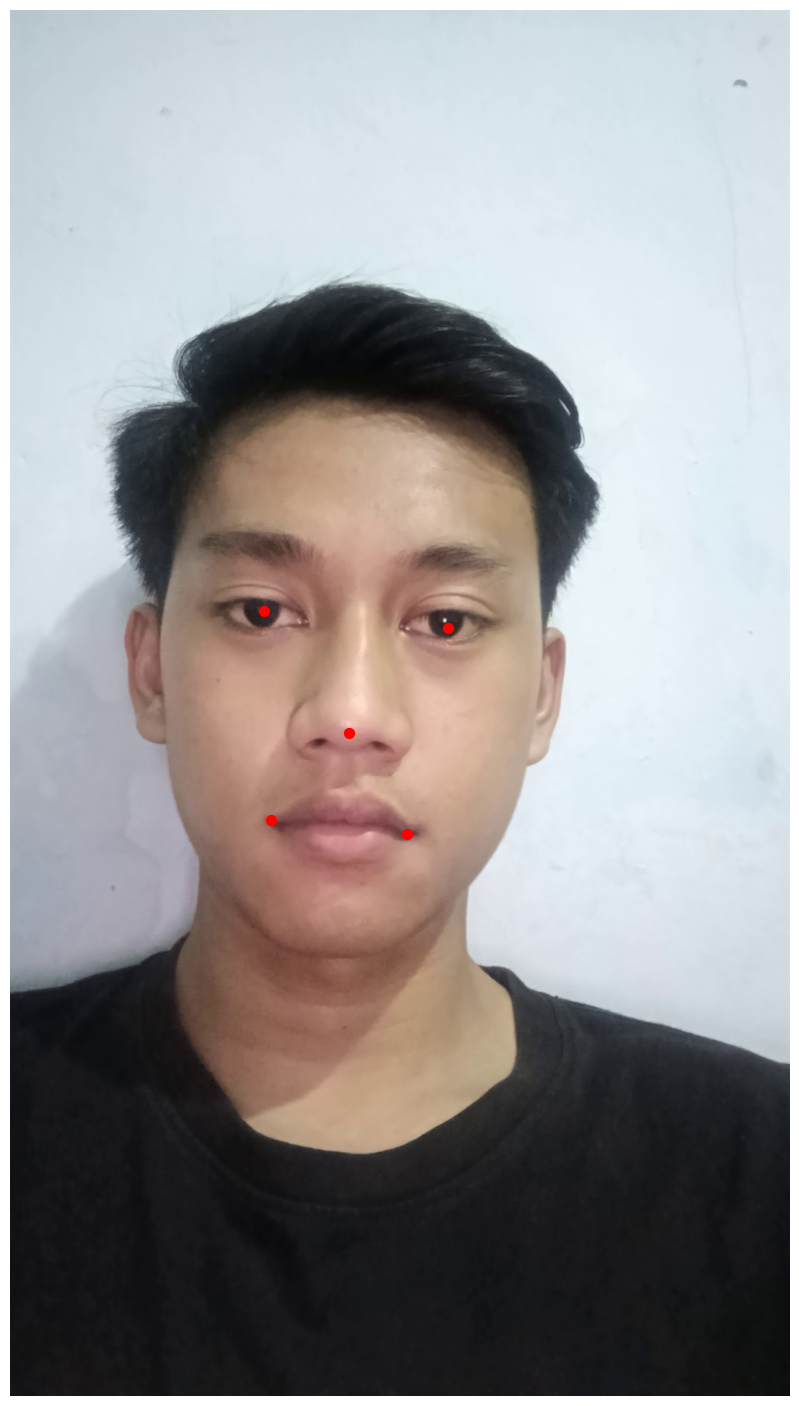

In [8]:
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt

# Load an image using OpenCV
image_path = 'dataset_self_full/active/active (3)_frame_8.jpg'
image = cv2.imread(image_path)

# Detect faces and landmarks in the image
faces = RetinaFace.detect_faces(image_path)

if faces is None:
    print("No faces detected.")
else:
    # Specify the figure size (width, height in inches)
    plt.figure(figsize=(20, 18))  # You can adjust these values as needed
    
    # Display the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Plot each detected face's landmarks
    for face_id, face_info in faces.items():
        landmarks = face_info['landmarks']
        print(f"Face ID: {face_id}, Landmarks: {landmarks}")
        
        # Plotting landmarks
        for key, point in landmarks.items():
            plt.scatter(point[0], point[1], s=200, marker='.', c='r')
    
    plt.axis('off')
    plt.show()


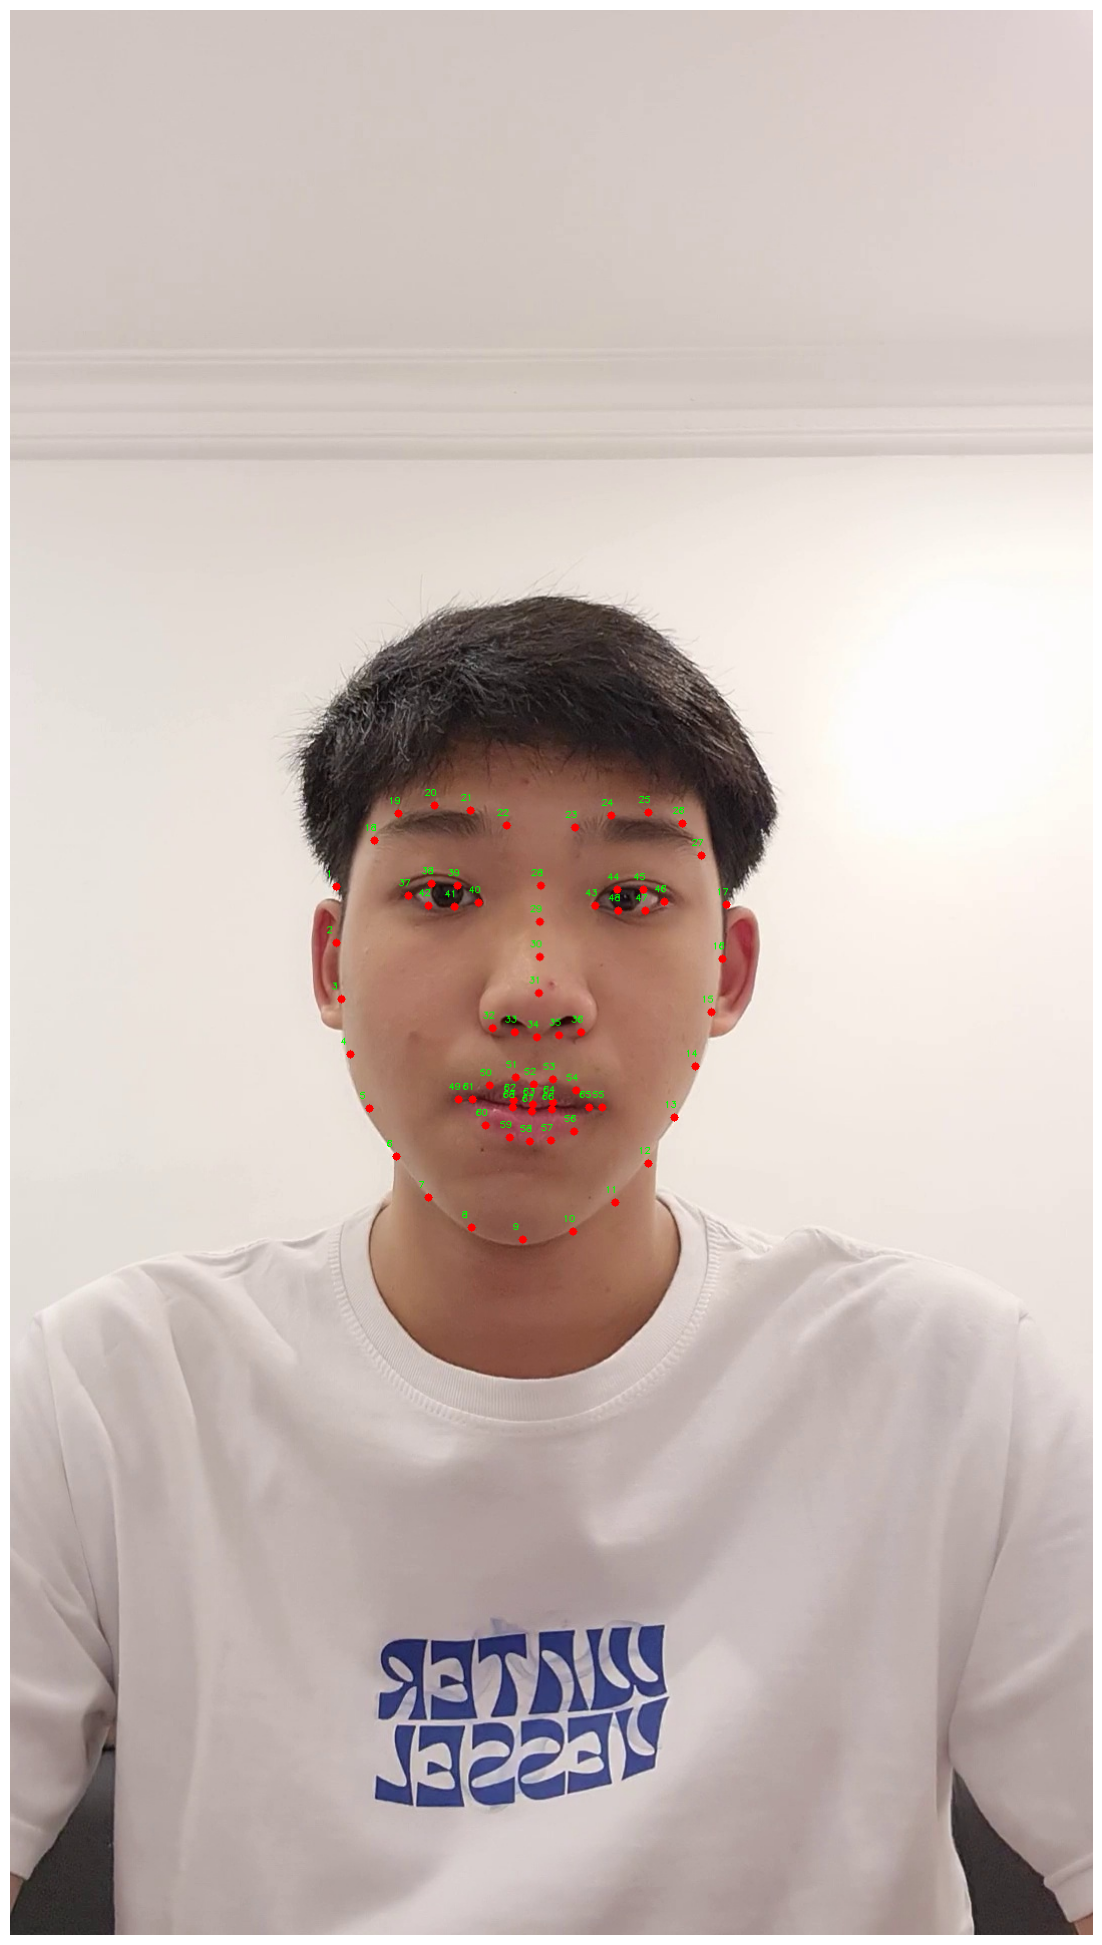

In [37]:
import dlib
import cv2
import matplotlib.pyplot as plt
from imutils import face_utils

# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor.
p = "shape_predictor_68_face_landmarks.dat"  # Path to the dlib pre-trained model.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

# Load the image using OpenCV
image_path = "dataset_self_full/active/active (20)_frame_1.jpg"  # Placeholder for the image path.
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
rects = detector(gray, 1)

# Loop over the face detections
for (i, rect) in enumerate(rects):
    # Determine the facial landmarks for the face region, then convert the facial landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # # Convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x, y, w, h)], then draw the face bounding box
    # (x, y, w, h) = face_utils.rect_to_bb(rect)
    # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # # Show the face number
    # cv2.putText(image, f"Face #{i + 1}", (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)

    # Loop over the (x, y)-coordinates for the facial landmarks and draw them on the image
    for (j, (x, y)) in enumerate(shape):
        cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
        cv2.putText(image, str(j + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

# Convert image to RGB (from BGR, which OpenCV uses) for matplotlib to display correctly
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with matplotlib
plt.figure(figsize=(25, 25))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


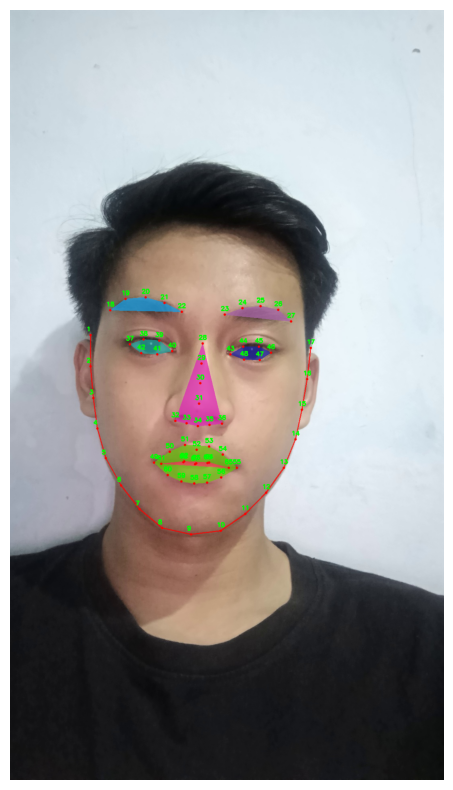

In [11]:
# Adjusting the code to increase the size of the landmark points and the font size of the numbers.

# Load the necessary libraries
import dlib
import cv2
import matplotlib.pyplot as plt
from imutils import face_utils

# Function to annotate the landmarks on the face
def annotate_landmarks(image, landmarks):
    # Increase the size of the landmarks and font size for visibility
    for (j, (x, y)) in enumerate(landmarks):
        cv2.circle(image, (x, y), 3, (0, 0, 255), -1)  # Increase the point size
        cv2.putText(image, str(j + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Increase the font size

    return image

# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Load the image using OpenCV
image_path = "dataset_self_full/active/active (3)_frame_8.jpg"  # Placeholder for the image path
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the grayscale image
faces = detector(gray, 1)

# Loop over the face detections
for (i, face) in enumerate(faces):
    # Determine the facial landmarks for the face region
    shape = predictor(gray, face)
    shape = face_utils.shape_to_np(shape)

    # Draw the face bounding box and annotate it
    image = face_utils.visualize_facial_landmarks(image, shape)
    image = annotate_landmarks(image, shape)

# Convert the image to RGB before displaying with matplotlib (OpenCV uses BGR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with the annotated landmarks
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
